# Music and Mental Health
### CSE 6040 Extra Credit Analysis
### Spring 2023

## Background

From August to November 2022, Catherine Rasgaitis distributed a Google Form both online, through several social media platforms, and physically, through business cards and posters placed in various public locations. The brief form aimed to gather information in regards to respondents' music preferences and self-reported mental health status in hopes of providing insights about the relationships between music taste and mental health, as well as guiding future expansion of music therapy (MT) research and development (Rasgaitis, 2022). 

I hope to explore potential relationships between different musical preferences and the ranked mental illnesses present in the dataset by way of comparing logistic regression models to classify whether or not someone would self-identify with Anxiety, Depression, Insomnia, or OCD based on either music identity or music taste. 

For the purpose of this analysis, *Music Identity* can be defined by "social and cultural roles within music" and *Music Taste* as "individual patterns of preference" (Hargreaves et al., 2002). Within the dataset, I have designated specific contributing variables within the dataset as either an identity factor (age hours spent per day listening to music, if they listen to music while working, if they identify as an instrumentalist, if they identify as a composer, if they explore different musical genres regularly, if they listen to music in foreign languages frequently, and whether or not they feel music has an effect on mental health) or taste factor (how frequently they listen to each of the following genres: classical, country, EDM, folk, gospel, hip hop, jazz, K-pop, Latin, lofi, metal, pop, R&B, rap, rock, and video game music).

In exploring the given definitions of *Music Identity* and *Music Taste*, I hypothesize that *Music Identity* will have higher accuracy in classifying self-identified mental illness over *Music Taste*, as identity focuses more on one's established lifestyle and habits, whereas music taste focuses solely on the genres to which one listens which could be short-term influenced by emotions or current events. 

In the models, I will be using an α = 0.1 and an accuracy threshold of 70%, suggesting that I'm examining models with 90% confidence and prediction rates of at least 70% accurate.

## Set Up

To begin, I imported the modules I might need to conduct the analysis, as well as imported the Music and Mental Health Survey Data (Rasgaitis, 2022).

In [1]:
#importing necessary modules
import pandas as pd
import numpy as np
from numpy import mean, std
from IPython.display import display
from math import isnan
import seaborn as sns
import scipy
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import statsmodels.api as sm
from statsmodels.formula.api import logit

In [2]:
#import MxMH dataset
dat = pd.read_csv("mxmh-survey.csv".format())

## Data Cleaning

In examining the dataset, I isolated the variables which I do not want to include as part of the analysis: Timestamp, Primary streaming service, Fav genre, BPM, and Permissions. 

I decided to remove *Timestamp* and *Permissions*, as those are not predictors for the models and only iterate when the observations occurred and whether the participant consented to being part of the study. I also chose to remove *Primary streaming service*, *Fav genre*, and *BPM*, as while those factors could be considered as part of Music Identity, I felt as though streaming services could depend too much on one's financial situation and not be very telling and that favorite genre fell too closely with the Music Taste categories and could be redundant in the analysis. BPM was an optional question that most participants chose not to respond to, as it requires more in-depth musical knowledge regarding the tempo of the music to which you most frequently listen, so I removed it since it would significantly reduce the sample size when removing NA values. 

After removing rows that contained NA values (Which would be where participants skipped over questions) to ensure that the columns each contained the same number of observations, I cleaned the data and recoded some column headers and values. 

Column headers that contain more than one word or a special character (i.e. Music effects or R&B) were recoded so that they would be more-easily read into models for analysis (i.e. Music_effects or R_B). Then, in order to ease analysis, I recoded some categorical variables as numbers. The frequency questions asking how frequently one listens to each genre of music were coded on a scale of 1 to 4, with 1 corresponding to "Never" and 4 corresponding to "Very frequently". Questions asking whether one identifies as a composer or instrumentalist, for example, were recoded as 0 (No) and 1 (Yes). Lastly, as participants were asked if they felt music has an effect on their mental health, those who responded feeling it has a positive effect were recoded as 1, those who responded feeling it has a negative effect were recoded as -1, and those who responded feeling it has no effect were recoded as 0.

For the purpose of performing logistic regression, I recoded the response variables (Anxiety, Depression, Insomnia, and OCD) as binary variables. Originally, participants self-ranked their experiences with each mental illness, from 0 (I do not experience this) to 10 (I experience this regularly, constantly/or to an extreme), and so for this analysis, anyone who responded with 5 or less was coded as 0 (not self-identifying as having the mental illness) and anyone who responded with higher than 5 was coded as 1 (self-identifying as having the mental illness). 

After fully cleaning the dataset, I set all values in the data as integers to ensure all data was the correct type before performing the analysis. 


In [3]:
#Build pandas dataframe out of dataset
dat = pd.DataFrame(dat)

#checking headers to see what data is present
dat.columns.values

array(['Timestamp', 'Age', 'Primary streaming service', 'Hours per day',
       'While working', 'Instrumentalist', 'Composer', 'Fav genre',
       'Exploratory', 'Foreign languages', 'BPM', 'Frequency [Classical]',
       'Frequency [Country]', 'Frequency [EDM]', 'Frequency [Folk]',
       'Frequency [Gospel]', 'Frequency [Hip hop]', 'Frequency [Jazz]',
       'Frequency [K pop]', 'Frequency [Latin]', 'Frequency [Lofi]',
       'Frequency [Metal]', 'Frequency [Pop]', 'Frequency [R&B]',
       'Frequency [Rap]', 'Frequency [Rock]',
       'Frequency [Video game music]', 'Anxiety', 'Depression',
       'Insomnia', 'OCD', 'Music effects', 'Permissions'], dtype=object)

In [4]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 736 entries, 0 to 735
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Timestamp                     736 non-null    object 
 1   Age                           735 non-null    float64
 2   Primary streaming service     735 non-null    object 
 3   Hours per day                 736 non-null    float64
 4   While working                 733 non-null    object 
 5   Instrumentalist               732 non-null    object 
 6   Composer                      735 non-null    object 
 7   Fav genre                     736 non-null    object 
 8   Exploratory                   736 non-null    object 
 9   Foreign languages             732 non-null    object 
 10  BPM                           629 non-null    float64
 11  Frequency [Classical]         736 non-null    object 
 12  Frequency [Country]           736 non-null    object 
 13  Frequ

In [5]:
dat.head()

,Timestamp,Age,Primary streaming service,Hours per day,While working,Instrumentalist,Composer,Fav genre,Exploratory,Foreign languages,...,Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music],Anxiety,Depression,Insomnia,OCD,Music effects,Permissions
0,8/27/2022 19:29,18.0,Spotify,3.0,Yes,Yes,Yes,Latin,Yes,Yes,...,Sometimes,Very frequently,Never,Sometimes,3.0,0.0,1.0,0.0,NaN,I understand.
1,8/27/2022 19:57,63.0,Pandora,1.5,Yes,No,No,Rock,Yes,No,...,Sometimes,Rarely,Very frequently,Rarely,7.0,2.0,2.0,1.0,NaN,I understand.
2,8/27/2022 21:28,18.0,Spotify,4.0,No,No,No,Video game music,No,Yes,...,Never,Rarely,Rarely,Very frequently,7.0,7.0,10.0,2.0,No effect,I understand.
3,8/27/2022 21:40,61.0,YouTube Music,2.5,Yes,No,Yes,Jazz,Yes,Yes,...,Sometimes,Never,Never,Never,9.0,7.0,3.0,3.0,Improve,I understand.
4,8/27/2022 21:54,18.0,Spotify,4.0,Yes,No,No,R&B,Yes,No,...,Very frequently,Very frequently,Never,Rarely,7.0,2.0,5.0,9.0,Improve,I understand.


In [6]:
#remove unwanted columns
dat = dat.drop(['Timestamp', 'Primary streaming service', 'Fav genre', 'BPM', 'Permissions'], axis=1)

#remove any rows containing NA values
dat = dat.dropna()

#rename columns
dat.rename(columns={'Hours per day': 'Hours_per_day',
                    'While working': 'While_working',
                    'Foreign languages': 'Foreign_languages',
                    'Music effects': 'Music_effects',
                    'Frequency [Classical]': 'Classical',
                    'Frequency [Country]': 'Country',
                    'Frequency [EDM]': 'EDM',
                    'Frequency [Folk]': 'Folk',
                    'Frequency [Gospel]': 'Gospel',
                    'Frequency [Hip hop]': 'Hip_hop',
                    'Frequency [Jazz]': 'Jazz',
                    'Frequency [K pop]': 'K_pop',
                    'Frequency [Latin]': 'Latin',
                    'Frequency [Lofi]': 'Lofi',
                    'Frequency [Metal]': 'Metal',
                    'Frequency [Pop]': 'Pop',
                    'Frequency [R&B]': 'R_B',
                    'Frequency [Rap]': 'Rap',
                    'Frequency [Rock]': 'Rock',
                    'Frequency [Video game music]': 'Video_game_music'}, inplace=True)

#recode categorical data
for column in dat:
  dat.loc[dat[column] == "Yes", column] = 1
  dat.loc[dat[column] == "No", column] = 0
  dat.loc[dat[column] == "Never", column] = 1
  dat.loc[dat[column] == "Rarely", column] = 2
  dat.loc[dat[column] == "Sometimes", column] = 3
  dat.loc[dat[column] == "Very frequently", column] = 4

dat.loc[dat["Music_effects"] == "No effect", "Music_effects"] = 0
dat.loc[dat["Music_effects"] == "Improve", "Music_effects"] = 1
dat.loc[dat["Music_effects"] == "Worsen", "Music_effects"] = -1

#recoding response variables to be binary
dat.loc[dat["Anxiety"] <= 5, "Anxiety"] = 0
dat.loc[dat["Anxiety"] != 0, "Anxiety"] = 1

dat.loc[dat["Depression"] <= 5, "Depression"] = 0
dat.loc[dat["Depression"] != 0, "Depression"] = 1

dat.loc[dat["Insomnia"] <= 5, "Insomnia"] = 0
dat.loc[dat["Insomnia"] != 0, "Insomnia"] = 1

dat.loc[dat["OCD"] <= 5, "OCD"] = 0
dat.loc[dat["OCD"] != 0, "OCD"] = 1

#all data set as integers
dat = dat.astype(int)

In [7]:
#Rechecking data column types
dat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 719 entries, 2 to 735
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Age                719 non-null    int64
 1   Hours_per_day      719 non-null    int64
 2   While_working      719 non-null    int64
 3   Instrumentalist    719 non-null    int64
 4   Composer           719 non-null    int64
 5   Exploratory        719 non-null    int64
 6   Foreign_languages  719 non-null    int64
 7   Classical          719 non-null    int64
 8   Country            719 non-null    int64
 9   EDM                719 non-null    int64
 10  Folk               719 non-null    int64
 11  Gospel             719 non-null    int64
 12  Hip_hop            719 non-null    int64
 13  Jazz               719 non-null    int64
 14  K_pop              719 non-null    int64
 15  Latin              719 non-null    int64
 16  Lofi               719 non-null    int64
 17  Metal           

## Music Identity

I built the Music Identity dataframe by narrowing down the variables to only those I designated as identity factors: Age, Hours_per_day, While_Working, Instrumentalist, Composer, Exploratory, Foreign_languages, and Music_effects. 

Below, I displayed the first and last five observations in the dat_identity dataframe.

In [8]:
#music identity dataframe
dat_identity = dat[['Age', 'Hours_per_day','While_working', 'Instrumentalist', 'Composer',
       'Exploratory', 'Foreign_languages', 'Music_effects','Anxiety', 'Depression',
       'Insomnia', 'OCD']]

#first 5 observations
display(dat_identity.head())

#last 5 observations
display(dat_identity.tail())

,Age,Hours_per_day,While_working,Instrumentalist,Composer,Exploratory,Foreign_languages,Music_effects,Anxiety,Depression,Insomnia,OCD
2,18,4,0,0,0,0,1,0,1,1,1,0
3,61,2,1,0,1,1,1,1,1,1,0,0
4,18,4,1,0,0,1,0,1,1,0,0,1
5,18,5,1,1,1,1,1,1,1,1,1,1
6,18,3,1,1,0,1,1,1,0,1,1,0


,Age,Hours_per_day,While_working,Instrumentalist,Composer,Exploratory,Foreign_languages,Music_effects,Anxiety,Depression,Insomnia,OCD
731,17,2,1,1,0,1,1,1,1,1,0,1
732,18,1,1,1,0,1,1,1,0,0,0,0
733,19,6,1,0,1,1,0,1,0,0,0,0
734,19,5,1,1,0,0,0,1,0,0,0,0
735,29,2,1,0,0,1,1,1,0,0,0,0


To examine the relationships between the variables within the dataframe, I visualized the data with a correlation matrix. Looking at the matrix, it doesn't seem as though any of the variables are strongly correlated, save for Anxiety/Depression and Instrumentalist/Composer, both of which make sense given the nature of those items and how those who identify with one are likely to identify with the other. Another correlation that tracks would be Hours_per_day and While_working, which makes sense since those who listen to music while working may listen to music more than others. OCD and Anxiety also seem somewhat correlated, which makes sense as well given OCD is considered an anxiety disorder. Interestingly, While_working and Music_effects have a slightly positive correlation.

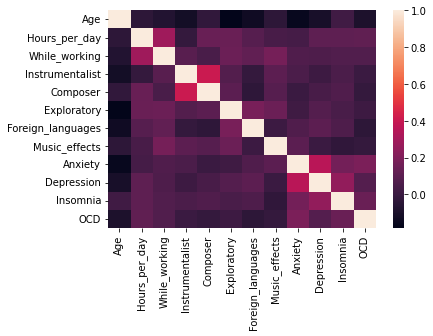

In [9]:
corr_matrix = dat_identity.corr()
sns.heatmap(corr_matrix)
plt.show()

Before beginning to explore the individual models, I split the identity dataset into training and test sets in order to build and test the models.

In [10]:
#split data into training and test sets
dat_identity_train, dat_identity_test = train_test_split(dat_identity, test_size = 0.20, random_state = 42)

### Identity - Anxiety


Looking at the regression plots, there mostly seems to be mildly linear relationships, which is not very telling when discussing categorical or binary data. Age, Hours_per_day, and Music_effects have the strongest relationships with Anxiety, with Composer and Exploratory having almost no discernible relationship within the regression plots.

<AxesSubplot:xlabel='Music_effects', ylabel='Anxiety'>

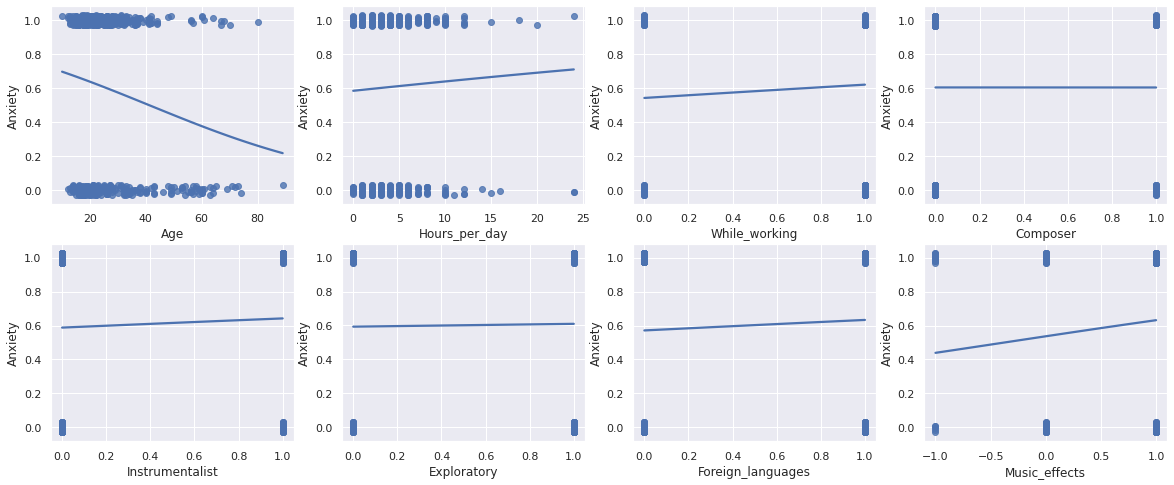

In [11]:
#regression plots for predictors vs response
sns.set()

fig, axes = plt.subplots(2, 4, figsize=(20,8))

sns.regplot(x = "Age", y = "Anxiety", y_jitter = 0.03, data = dat_identity, logistic = True, ci = None, ax=axes[0,0])
sns.regplot(x = "Hours_per_day", y = "Anxiety", y_jitter = 0.03, data = dat_identity, logistic = True, ci = None, ax=axes[0,1])
sns.regplot(x = "While_working", y = "Anxiety", y_jitter = 0.03, data = dat_identity, logistic = True, ci = None, ax=axes[0,2])
sns.regplot(x = "Composer", y = "Anxiety", y_jitter = 0.03, data = dat_identity, logistic = True, ci = None, ax=axes[0,3])
sns.regplot(x = "Instrumentalist", y = "Anxiety", y_jitter = 0.03, data = dat_identity, logistic = True, ci = None, ax=axes[1,0])
sns.regplot(x = "Exploratory", y = "Anxiety", y_jitter = 0.03, data = dat_identity, logistic = True, ci = None, ax=axes[1,1])
sns.regplot(x = "Foreign_languages", y = "Anxiety", y_jitter = 0.03, data = dat_identity, logistic = True, ci = None, ax=axes[1,2])
sns.regplot(x = "Music_effects", y = "Anxiety", y_jitter = 0.03, data = dat_identity, logistic = True, ci = None, ax=axes[1,3])

I built the logistic regression model using all eight predictors against the response variable. Using an α = 0.1, only three of the model coefficients are statistically significant, holding all other factors constant: the intercept, Age, and Music_effects. 

The model overall seems to be a good fit for the data, given the LLR p-value 0.0022 < 0.1.

In examining the confusion matrix, the accuracy of the model in predicting whether or not someone would identify as having anxiety is approximately 66%, which while higher than 50%, does not meet my set threshold of 70%. 

In [12]:
#building logistic regression model
formula_anxiety_id = ("Anxiety ~ Age + Hours_per_day + While_working + Instrumentalist + Composer + Exploratory + Foreign_languages + Music_effects")
model_anxiety_id = logit(formula = formula_anxiety_id, data = dat_identity_train).fit()
print(model_anxiety_id.summary())

#predictions and confusion matrix
pred_a = model_anxiety_id.predict(exog = dat_identity_test)
cutoff = 0.5
y_pred = np.where(pred_a > cutoff, 1, 0)
y_actual = dat_identity_test["Anxiety"]
conf_matrix = pd.crosstab(y_actual, y_pred,
                          rownames = ["Actual"],
                          colnames = ["Predicted"],
                          margins = True)
print(conf_matrix)

#calculating accuracy
acc_id_anxiety = accuracy_score(y_actual, y_pred)
print(acc_id_anxiety)

Optimization terminated successfully.
         Current function value: 0.652773
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                Anxiety   No. Observations:                  575
Model:                          Logit   Df Residuals:                      566
Method:                           MLE   Df Model:                            8
Date:                Thu, 20 Apr 2023   Pseudo R-squ.:                 0.03108
Time:                        11:10:28   Log-Likelihood:                -375.34
converged:                       True   LL-Null:                       -387.38
Covariance Type:            nonrobust   LLR p-value:                  0.002223
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.5880      0.339      1.732      0.083      -0.077       1.253
Age     

### Identity - Depression

The regression plots are similar to those for Anxiety, with the strongest relationships appearing with Age, Hours_per_day, and Foreign_language. Instrumentalist and Music_effects seem to have almost no discernible relationship. However, the linear relationships may not be meaningful given the categorical nature of the variables. 

<AxesSubplot:xlabel='Music_effects', ylabel='Depression'>

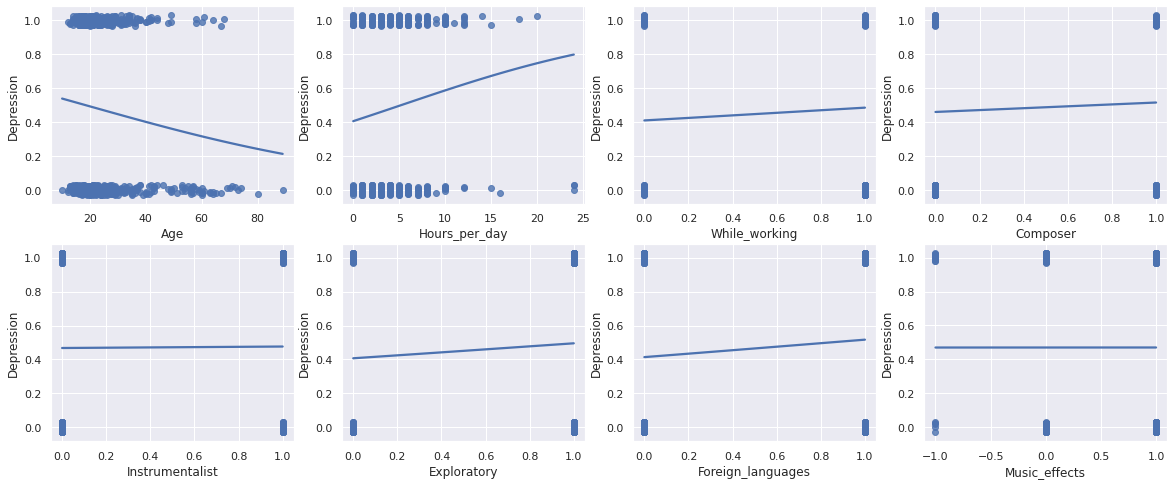

In [13]:
#regression plots for predictors and response variable
sns.set()

fig, axes = plt.subplots(2, 4, figsize=(20,8))

sns.regplot(x = "Age", y = "Depression", y_jitter = 0.03, data = dat_identity, logistic = True, ci = None, ax=axes[0,0])
sns.regplot(x = "Hours_per_day", y = "Depression", y_jitter = 0.03, data = dat_identity, logistic = True, ci = None, ax=axes[0,1])
sns.regplot(x = "While_working", y = "Depression", y_jitter = 0.03, data = dat_identity, logistic = True, ci = None, ax=axes[0,2])
sns.regplot(x = "Composer", y = "Depression", y_jitter = 0.03, data = dat_identity, logistic = True, ci = None, ax=axes[0,3])
sns.regplot(x = "Instrumentalist", y = "Depression", y_jitter = 0.03, data = dat_identity, logistic = True, ci = None, ax=axes[1,0])
sns.regplot(x = "Exploratory", y = "Depression", y_jitter = 0.03, data = dat_identity, logistic = True, ci = None, ax=axes[1,1])
sns.regplot(x = "Foreign_languages", y = "Depression", y_jitter = 0.03, data = dat_identity, logistic = True, ci = None, ax=axes[1,2])
sns.regplot(x = "Music_effects", y = "Depression", y_jitter = 0.03, data = dat_identity, logistic = True, ci = None, ax=axes[1,3])

I built the logistic regression model using all eight predictors against the response variable. Using an α = 0.1, only two of the model coefficients are statistically significant, holding all other factors constant: Age and Foreign_languages.

The model overall seems to be a good fit for the data, given the LLR p-value 0.0028 < 0.1.

In examining the confusion matrix, the accuracy of the model in predicting whether or not someone would identify as having anxiety is approximately 57%, which while higher than 50%, does not meet my set threshold of 70%. 

In [14]:
#building regression model for depression
formula_depression_id = ("Depression ~ Age + Hours_per_day + While_working + Instrumentalist + Composer + Exploratory + Foreign_languages + Music_effects")
model_depression_id = logit(formula = formula_depression_id, data = dat_identity_train).fit()
print(model_depression_id.summary())

#predictions and confusion matrix
pred_d = model_depression_id.predict(exog = dat_identity_test)
cutoff = 0.5
y_pred = np.where(pred_d > cutoff, 1, 0)
y_actual = dat_identity_test["Depression"]
conf_matrix = pd.crosstab(y_actual, y_pred,
                          rownames = ["Actual"],
                          colnames = ["Predicted"],
                          margins = True)
print(conf_matrix)

#calculating model accuracy
acc_id_depression = accuracy_score(y_actual, y_pred)
print(acc_id_depression)

Optimization terminated successfully.
         Current function value: 0.672055
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:             Depression   No. Observations:                  575
Model:                          Logit   Df Residuals:                      566
Method:                           MLE   Df Model:                            8
Date:                Thu, 20 Apr 2023   Pseudo R-squ.:                 0.02950
Time:                        11:10:29   Log-Likelihood:                -386.43
converged:                       True   LL-Null:                       -398.18
Covariance Type:            nonrobust   LLR p-value:                  0.002790
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.4829      0.341     -1.418      0.156      -1.150       0.185
Age     

### Identity - Insomnia

The regression plots are similar to those for previous response variables, with the strongest relationships appearing with Hours_per_day. All predictors seem to have a somewhat linear relationship with Anxiety. However, the linear relationships may not be meaningful given the categorical nature of the variables. 

<AxesSubplot:xlabel='Music_effects', ylabel='Insomnia'>

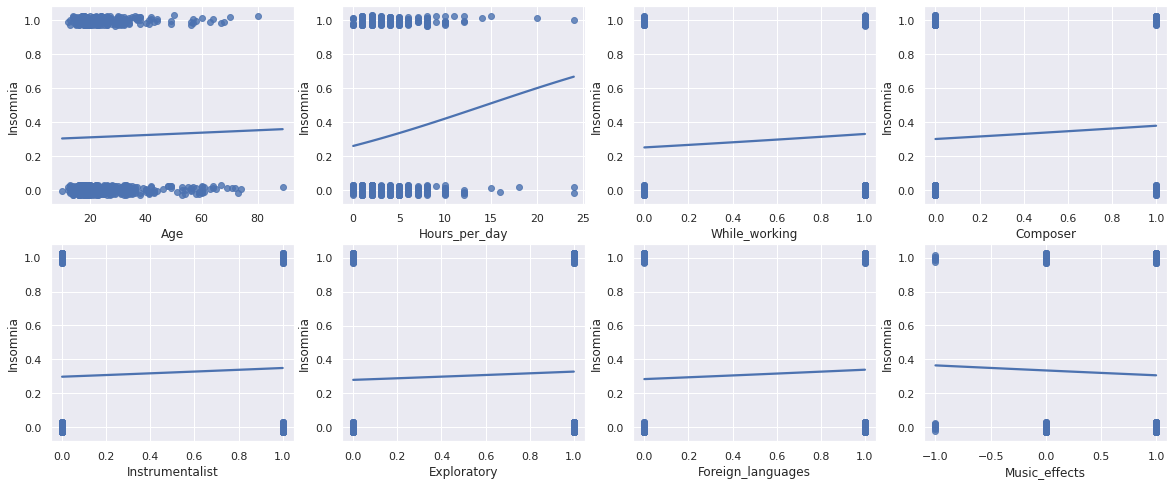

In [15]:
#regression plots for predictors and response variable

sns.set()

fig, axes = plt.subplots(2, 4, figsize=(20,8))

sns.regplot(x = "Age", y = "Insomnia", y_jitter = 0.03, data = dat, logistic = True, ci = None, ax=axes[0,0])
sns.regplot(x = "Hours_per_day", y = "Insomnia", y_jitter = 0.03, data = dat, logistic = True, ci = None, ax=axes[0,1])
sns.regplot(x = "While_working", y = "Insomnia", y_jitter = 0.03, data = dat, logistic = True, ci = None, ax=axes[0,2])
sns.regplot(x = "Composer", y = "Insomnia", y_jitter = 0.03, data = dat, logistic = True, ci = None, ax=axes[0,3])
sns.regplot(x = "Instrumentalist", y = "Insomnia", y_jitter = 0.03, data = dat, logistic = True, ci = None, ax=axes[1,0])
sns.regplot(x = "Exploratory", y = "Insomnia", y_jitter = 0.03, data = dat, logistic = True, ci = None, ax=axes[1,1])
sns.regplot(x = "Foreign_languages", y = "Insomnia", y_jitter = 0.03, data = dat, logistic = True, ci = None, ax=axes[1,2])
sns.regplot(x = "Music_effects", y = "Insomnia", y_jitter = 0.03, data = dat, logistic = True, ci = None, ax=axes[1,3])

I built the logistic regression model using all eight predictors against the response variable. Using an α = 0.1, only two of the model coefficients are statistically significant, holding all other factors constant: the Intercept and Hours_per_day.

The model overall seems to be a good fit for the data, given the LLR p-value 0.0287 < 0.1.

In examining the confusion matrix, the accuracy of the model in predicting whether or not someone would identify as having anxiety is approximately 74%, which meets my set minimum threshold of 70%.

In [16]:
#building regression model for insomnia and predictors
formula_insomnia_id = ("Insomnia ~ Age + Hours_per_day + While_working + Instrumentalist + Composer + Exploratory + Foreign_languages + Music_effects")
model_insomnia_id = logit(formula = formula_insomnia_id, data = dat_identity_train).fit()
print(model_insomnia_id.summary())

#predictions and confusion matrix
pred_i = model_insomnia_id.predict(exog = dat_identity_test)
cutoff = 0.5
y_pred = np.where(pred_i > cutoff, 1, 0)
y_actual = dat_identity_test["Insomnia"]
conf_matrix = pd.crosstab(y_actual, y_pred,
                          rownames = ["Actual"],
                          colnames = ["Predicted"],
                          margins = True)
print(conf_matrix)

#calculating model accuracy
acc_id_insomnia = accuracy_score(y_actual, y_pred)
print(acc_id_insomnia)

Optimization terminated successfully.
         Current function value: 0.620808
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:               Insomnia   No. Observations:                  575
Model:                          Logit   Df Residuals:                      566
Method:                           MLE   Df Model:                            8
Date:                Thu, 20 Apr 2023   Pseudo R-squ.:                 0.02344
Time:                        11:10:30   Log-Likelihood:                -356.96
converged:                       True   LL-Null:                       -365.53
Covariance Type:            nonrobust   LLR p-value:                   0.02874
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -1.5040      0.365     -4.117      0.000      -2.220      -0.788
Age     

### Identity - OCD

The regression plots are similar to those for previous response variables, with the strongest relationships appearing with Age and Hours_per_day. There is almost no discernible relationship between OCD and Instrumentalist and Exploratory. However, the linear relationships may not be meaningful given the categorical nature of the variables.

<AxesSubplot:xlabel='Music_effects', ylabel='OCD'>

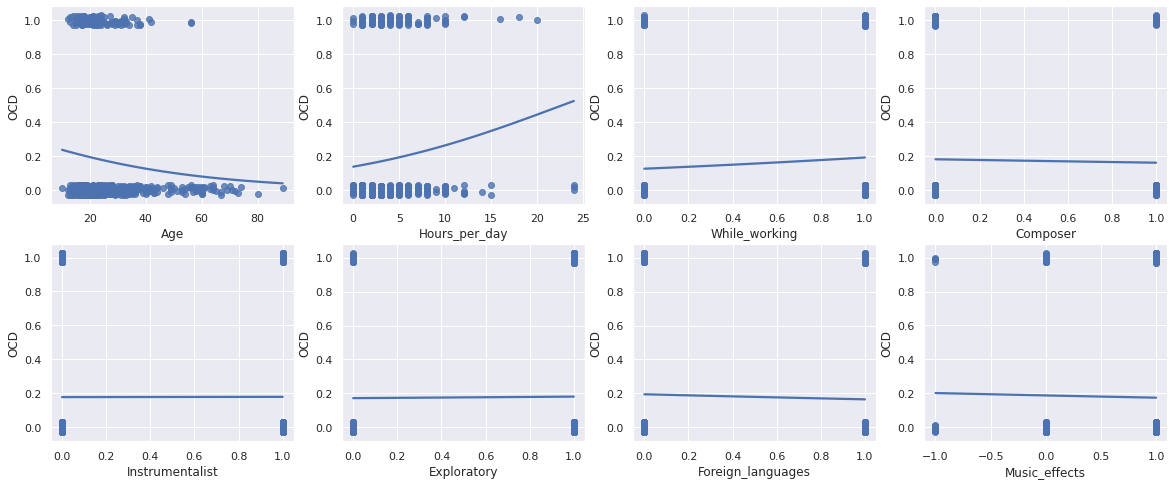

In [17]:
#regression plots for predictors and response variable

sns.set()

fig, axes = plt.subplots(2, 4, figsize=(20,8))

sns.regplot(x = "Age", y = "OCD", y_jitter = 0.03, data = dat, logistic = True, ci = None, ax=axes[0,0])
sns.regplot(x = "Hours_per_day", y = "OCD", y_jitter = 0.03, data = dat, logistic = True, ci = None, ax=axes[0,1])
sns.regplot(x = "While_working", y = "OCD", y_jitter = 0.03, data = dat, logistic = True, ci = None, ax=axes[0,2])
sns.regplot(x = "Composer", y = "OCD", y_jitter = 0.03, data = dat, logistic = True, ci = None, ax=axes[0,3])
sns.regplot(x = "Instrumentalist", y = "OCD", y_jitter = 0.03, data = dat, logistic = True, ci = None, ax=axes[1,0])
sns.regplot(x = "Exploratory", y = "OCD", y_jitter = 0.03, data = dat, logistic = True, ci = None, ax=axes[1,1])
sns.regplot(x = "Foreign_languages", y = "OCD", y_jitter = 0.03, data = dat, logistic = True, ci = None, ax=axes[1,2])
sns.regplot(x = "Music_effects", y = "OCD", y_jitter = 0.03, data = dat, logistic = True, ci = None, ax=axes[1,3])

I built the logistic regression model using all eight predictors against the response variable. Using an α = 0.1, four of the model coefficients are statistically significant, holding all other factors constant: the Intercept, Age, Hours_per_day, and Foreign_languages.

The model overall seems to be a good fit for the data, given the LLR p-value 0.0241 < 0.1.

In examining the confusion matrix, the accuracy of the model in predicting whether or not someone would identify as having anxiety is approximately 81%, which meets my set minimum threshold of 70%.

In [18]:
#building regression model with predictors and response variable
formula_ocd_id = ("OCD ~ Age + Hours_per_day + While_working + Instrumentalist + Composer + Exploratory + Foreign_languages + Music_effects")
model_ocd_id = logit(formula = formula_ocd_id, data = dat_identity_train).fit()
print(model_ocd_id.summary())

#predictions and confusion matrix
pred_o = model_ocd_id.predict(exog = dat_identity_test)
cutoff = 0.5
y_pred = np.where(pred_o > cutoff, 1, 0)
y_actual = dat_identity_test["OCD"]
conf_matrix = pd.crosstab(y_actual, y_pred,
                          rownames = ["Actual"],
                          colnames = ["Predicted"],
                          margins = True)
print(conf_matrix)

#calculating model accuracy
acc_id_ocd = accuracy_score(y_actual, y_pred)
print(acc_id_ocd)

Optimization terminated successfully.
         Current function value: 0.449400
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                    OCD   No. Observations:                  575
Model:                          Logit   Df Residuals:                      566
Method:                           MLE   Df Model:                            8
Date:                Thu, 20 Apr 2023   Pseudo R-squ.:                 0.03300
Time:                        11:10:31   Log-Likelihood:                -258.40
converged:                       True   LL-Null:                       -267.22
Covariance Type:            nonrobust   LLR p-value:                   0.02412
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -1.2295      0.473     -2.601      0.009      -2.156      -0.303
Age     

## Music Taste

I built the Music Taste dataframe by narrowing down the variables to only those I designated as taste factors: CLassical, Country, EDM, Gospel, Hip_hop, Jazz, K_pop, Latin, Metal, Pop, R_B, Rap, Rock, and Video_game_music.

Below, I displayed the first and last five observations in the dat_taste dataframe.

In [19]:
#building music taste dataframe
dat_taste = dat[['Classical', 'Country', 'EDM', 'Folk', 'Gospel', 'Hip_hop',
                 'Jazz', 'K_pop', 'Latin', 'Lofi', 'Metal', 'Pop', 'R_B', 'Rap',
                 'Rock', 'Video_game_music','Anxiety', 'Depression','Insomnia', 'OCD']]

#first five observations
display(dat_taste.head())

#last five observations
display(dat_taste.tail())

,Classical,Country,EDM,Folk,Gospel,Hip_hop,Jazz,K_pop,Latin,Lofi,Metal,Pop,R_B,Rap,Rock,Video_game_music,Anxiety,Depression,Insomnia,OCD
2,1,1,4,1,1,2,2,4,1,3,3,2,1,2,2,4,1,1,1,0
3,3,1,1,2,3,1,4,3,4,3,1,3,3,1,1,1,1,1,0,0
4,1,1,2,1,2,4,1,4,3,3,1,3,4,4,1,2,1,0,0,1
5,2,3,1,1,1,3,4,4,2,4,2,4,4,4,4,1,1,1,1,1
6,3,1,2,3,2,2,3,1,2,2,2,2,2,1,1,3,0,1,1,0


,Classical,Country,EDM,Folk,Gospel,Hip_hop,Jazz,K_pop,Latin,Lofi,Metal,Pop,R_B,Rap,Rock,Video_game_music,Anxiety,Depression,Insomnia,OCD
731,4,2,1,3,1,3,2,1,3,2,2,4,1,2,4,1,1,1,0,1
732,2,2,1,1,1,1,2,1,1,2,1,4,1,1,3,3,0,0,0,0
733,2,3,3,2,2,4,2,2,2,3,2,3,3,3,2,2,0,0,0,0
734,4,1,1,1,1,1,2,1,1,1,1,1,1,1,1,3,0,0,0,0
735,3,2,4,3,2,4,4,3,1,2,1,3,4,4,4,2,0,0,0,0


To examine the relationships between the variables within the dataframe, I visualized the data with a correlation matrix. Looking at the matrix, more of the predictors seem to be correlated more strongly than in the identity dataset. Hip_hop is strongly correlated with both R_B and Rap, which makes sense given the nature of those musical genres, and the same applies to other correlated genres such as Rock and Folk, Country and Folk, or Rock and Metal. 


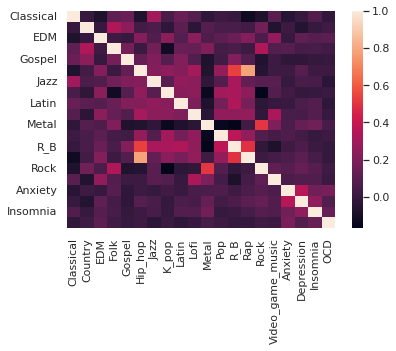

In [20]:
#correlation matrix cor prdictors and response variables
corr_matrix = dat_taste.corr()
sns.heatmap(corr_matrix)
plt.show()

Before beginning to explore the individual models, I split the taste dataset into training and test sets in order to build and test the models.

In [21]:
#splitting the dataset into training and test sets
dat_taste_train, dat_taste_test = train_test_split(dat_taste, test_size = 0.20, random_state = 42)

### Taste - Anxiety

Looking at the regression plots, there mostly seems to be mildly linear relationships, which is not very telling when discussing categorical or binary data. None of the predictors seem to have significantly strong relationships with Anxiety, though Folk appears slightly stronger than others.

<AxesSubplot:xlabel='Video_game_music', ylabel='Anxiety'>

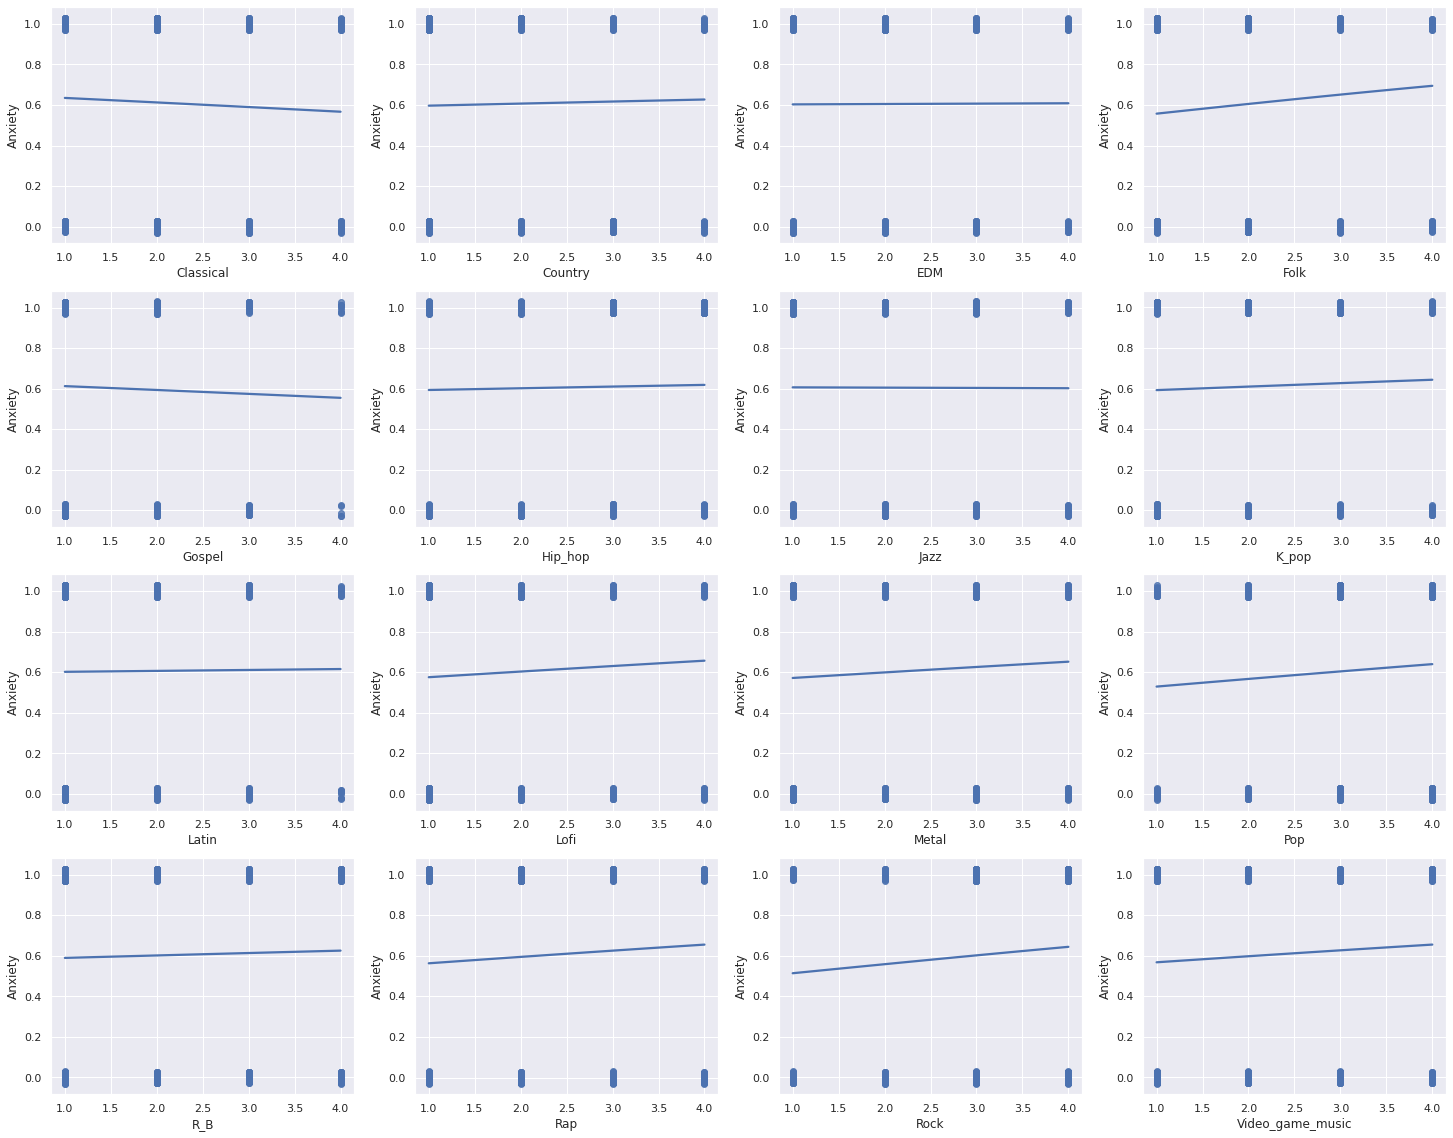

In [22]:
sns.set()

fig, axes = plt.subplots(4, 4, figsize=(25,20))

sns.regplot(x = "Classical", y = "Anxiety", y_jitter = 0.03, data = dat_taste, logistic = True, ci = None, ax=axes[0,0])
sns.regplot(x = "Country", y = "Anxiety", y_jitter = 0.03, data = dat_taste, logistic = True, ci = None, ax=axes[0,1])
sns.regplot(x = "EDM", y = "Anxiety", y_jitter = 0.03, data = dat_taste, logistic = True, ci = None, ax=axes[0,2])
sns.regplot(x = "Folk", y = "Anxiety", y_jitter = 0.03, data = dat_taste, logistic = True, ci = None, ax=axes[0,3])
sns.regplot(x = "Gospel", y = "Anxiety", y_jitter = 0.03, data = dat_taste, logistic = True, ci = None, ax=axes[1,0])
sns.regplot(x = "Hip_hop", y = "Anxiety", y_jitter = 0.03, data = dat_taste, logistic = True, ci = None, ax=axes[1,1])
sns.regplot(x = "Jazz", y = "Anxiety", y_jitter = 0.03, data = dat_taste, logistic = True, ci = None, ax=axes[1,2])
sns.regplot(x = "K_pop", y = "Anxiety", y_jitter = 0.03, data = dat_taste, logistic = True, ci = None, ax=axes[1,3])
sns.regplot(x = "Latin", y = "Anxiety", y_jitter = 0.03, data = dat_taste, logistic = True, ci = None, ax=axes[2,0])
sns.regplot(x = "Lofi", y = "Anxiety", y_jitter = 0.03, data = dat_taste, logistic = True, ci = None, ax=axes[2,1])
sns.regplot(x = "Metal", y = "Anxiety", y_jitter = 0.03, data = dat_taste, logistic = True, ci = None, ax=axes[2,2])
sns.regplot(x = "Pop", y = "Anxiety", y_jitter = 0.03, data = dat_taste, logistic = True, ci = None, ax=axes[2,3])
sns.regplot(x = "R_B", y = "Anxiety", y_jitter = 0.03, data = dat_taste, logistic = True, ci = None, ax=axes[3,0])
sns.regplot(x = "Rap", y = "Anxiety", y_jitter = 0.03, data = dat_taste, logistic = True, ci = None, ax=axes[3,1])
sns.regplot(x = "Rock", y = "Anxiety", y_jitter = 0.03, data = dat_taste, logistic = True, ci = None, ax=axes[3,2])
sns.regplot(x = "Video_game_music", y = "Anxiety", y_jitter = 0.03, data = dat_taste, logistic = True, ci = None, ax=axes[3,3])

I built the logistic regression model using all sixteen predictors against the response variable. Using an α = 0.1, three of the model coefficients are statistically significant, holding all other factors constant: Folk, Hip_hop, and Rap.

The model overall seems not to be a good fit for the data, given the LLR p-value 0.1086 > 0.1.

In examining the confusion matrix, the accuracy of the model in predicting whether or not someone would identify as having anxiety is approximately 66%, which does not meet my set minimum threshold of 70%.

In [23]:
formula_anxiety_ta = ("Anxiety ~ Classical + Country + EDM + Folk + Gospel + Hip_hop + Jazz + K_pop + Latin + Lofi + Metal + Pop + R_B + Rap + Rock + Video_game_music")
model_anxiety_ta = logit(formula = formula_anxiety_ta, data = dat_taste_train).fit()
print(model_anxiety_ta.summary())

pred_a = model_anxiety_ta.predict(exog = dat_taste_test)
cutoff = 0.5
y_pred = np.where(pred_a > cutoff, 1, 0)
y_actual = dat_taste_test["Anxiety"]
conf_matrix = pd.crosstab(y_actual, y_pred,
                          rownames = ["Actual"],
                          colnames = ["Predicted"],
                          margins = True)
print(conf_matrix)
acc_ta_anxiety = accuracy_score(y_actual, y_pred)
print(acc_ta_anxiety)

Optimization terminated successfully.
         Current function value: 0.653542
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                Anxiety   No. Observations:                  575
Model:                          Logit   Df Residuals:                      558
Method:                           MLE   Df Model:                           16
Date:                Thu, 20 Apr 2023   Pseudo R-squ.:                 0.02994
Time:                        11:10:34   Log-Likelihood:                -375.79
converged:                       True   LL-Null:                       -387.38
Covariance Type:            nonrobust   LLR p-value:                    0.1086
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.6426      0.530     -1.212      0.226      -1.682       0.397
Classical  

### Taste - Depression

The regression plots are similar to those for Anxiety, with the strongest relationships appearing with Country, EDM, Jazz, and Rock. However, the linear relationships may not be meaningful given the categorical nature of the variables.

<AxesSubplot:xlabel='Video_game_music', ylabel='Depression'>

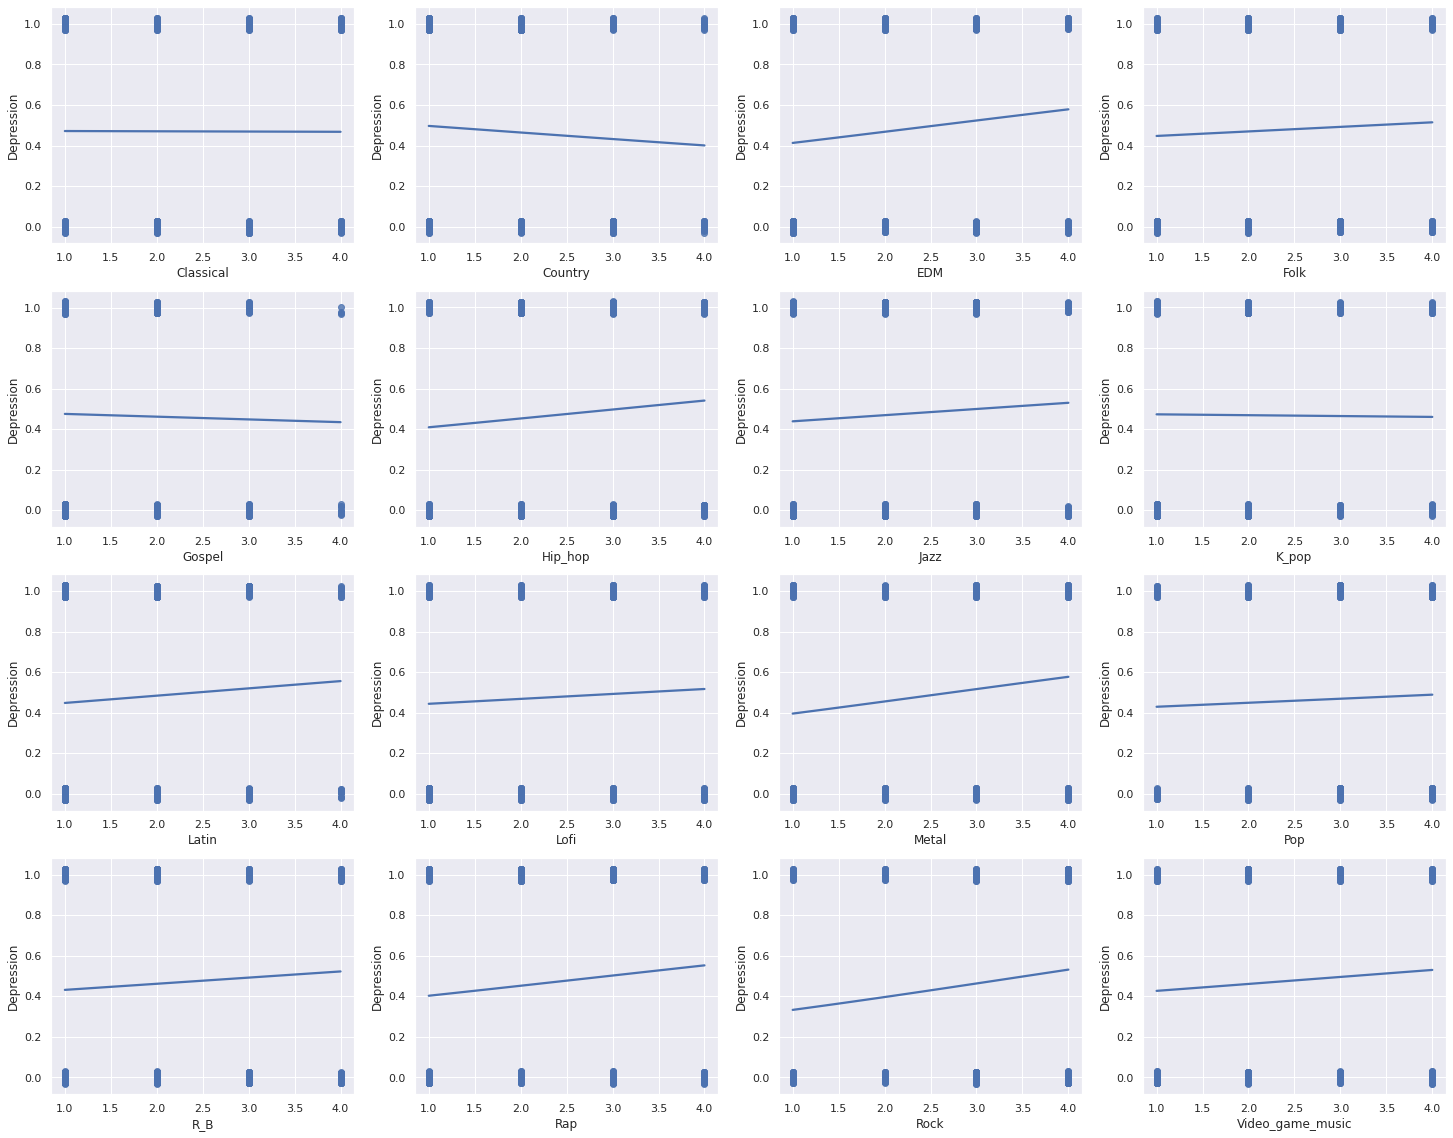

In [24]:
sns.set()

fig, axes = plt.subplots(4, 4, figsize=(25,20))

sns.regplot(x = "Classical", y = "Depression", y_jitter = 0.03, data = dat_taste, logistic = True, ci = None, ax=axes[0,0])
sns.regplot(x = "Country", y = "Depression", y_jitter = 0.03, data = dat_taste, logistic = True, ci = None, ax=axes[0,1])
sns.regplot(x = "EDM", y = "Depression", y_jitter = 0.03, data = dat_taste, logistic = True, ci = None, ax=axes[0,2])
sns.regplot(x = "Folk", y = "Depression", y_jitter = 0.03, data = dat_taste, logistic = True, ci = None, ax=axes[0,3])
sns.regplot(x = "Gospel", y = "Depression", y_jitter = 0.03, data = dat_taste, logistic = True, ci = None, ax=axes[1,0])
sns.regplot(x = "Hip_hop", y = "Depression", y_jitter = 0.03, data = dat_taste, logistic = True, ci = None, ax=axes[1,1])
sns.regplot(x = "Jazz", y = "Depression", y_jitter = 0.03, data = dat_taste, logistic = True, ci = None, ax=axes[1,2])
sns.regplot(x = "K_pop", y = "Depression", y_jitter = 0.03, data = dat_taste, logistic = True, ci = None, ax=axes[1,3])
sns.regplot(x = "Latin", y = "Depression", y_jitter = 0.03, data = dat_taste, logistic = True, ci = None, ax=axes[2,0])
sns.regplot(x = "Lofi", y = "Depression", y_jitter = 0.03, data = dat_taste, logistic = True, ci = None, ax=axes[2,1])
sns.regplot(x = "Metal", y = "Depression", y_jitter = 0.03, data = dat_taste, logistic = True, ci = None, ax=axes[2,2])
sns.regplot(x = "Pop", y = "Depression", y_jitter = 0.03, data = dat_taste, logistic = True, ci = None, ax=axes[2,3])
sns.regplot(x = "R_B", y = "Depression", y_jitter = 0.03, data = dat_taste, logistic = True, ci = None, ax=axes[3,0])
sns.regplot(x = "Rap", y = "Depression", y_jitter = 0.03, data = dat_taste, logistic = True, ci = None, ax=axes[3,1])
sns.regplot(x = "Rock", y = "Depression", y_jitter = 0.03, data = dat_taste, logistic = True, ci = None, ax=axes[3,2])
sns.regplot(x = "Video_game_music", y = "Depression", y_jitter = 0.03, data = dat_taste, logistic = True, ci = None, ax=axes[3,3])

I built the logistic regression model using all sixteen predictors against the response variable. Using an α = 0.1, three of the model coefficients are statistically significant, holding all other factors constant: the Intercept, Country, and EDM.

The model overall seems to be a good fit for the data, given the LLR p-value 0.0004 < 0.1.

In examining the confusion matrix, the accuracy of the model in predicting whether or not someone would identify as having anxiety is approximately 50%, which does not meet my set minimum threshold of 70%.

In [25]:
formula_depression_ta = ("Depression ~ Classical + Country + EDM + Folk + Gospel + Hip_hop + Jazz + K_pop + Latin + Lofi + Metal + Pop + R_B + Rap + Rock + Video_game_music")
model_depression_ta = logit(formula = formula_depression_ta, data = dat_taste_train).fit()
print(model_depression_ta.summary())

pred_a = model_depression_ta.predict(exog = dat_taste_test)
cutoff = 0.5
y_pred = np.where(pred_a > cutoff, 1, 0)
y_actual = dat_taste_test["Anxiety"]
conf_matrix = pd.crosstab(y_actual, y_pred,
                          rownames = ["Actual"],
                          colnames = ["Predicted"],
                          margins = True)
print(conf_matrix)
acc_ta_depression = accuracy_score(y_actual, y_pred)
print(acc_ta_depression)

Optimization terminated successfully.
         Current function value: 0.655781
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:             Depression   No. Observations:                  575
Model:                          Logit   Df Residuals:                      558
Method:                           MLE   Df Model:                           16
Date:                Thu, 20 Apr 2023   Pseudo R-squ.:                 0.05300
Time:                        11:10:37   Log-Likelihood:                -377.07
converged:                       True   LL-Null:                       -398.18
Covariance Type:            nonrobust   LLR p-value:                 0.0003679
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -2.1203      0.545     -3.887      0.000      -3.189      -1.051
Classical  

### Taste - Insomnia

The regression plots are similar to those for the previous response variables, with the strongest relationships appearing with Metal and Rock. Most seem to have somewhat linear relationships except for K_pop and R_B, which have no discernible relationships in the figures. However, the linear relationships may not be meaningful given the categorical nature of the variables.

<AxesSubplot:xlabel='Video_game_music', ylabel='Insomnia'>

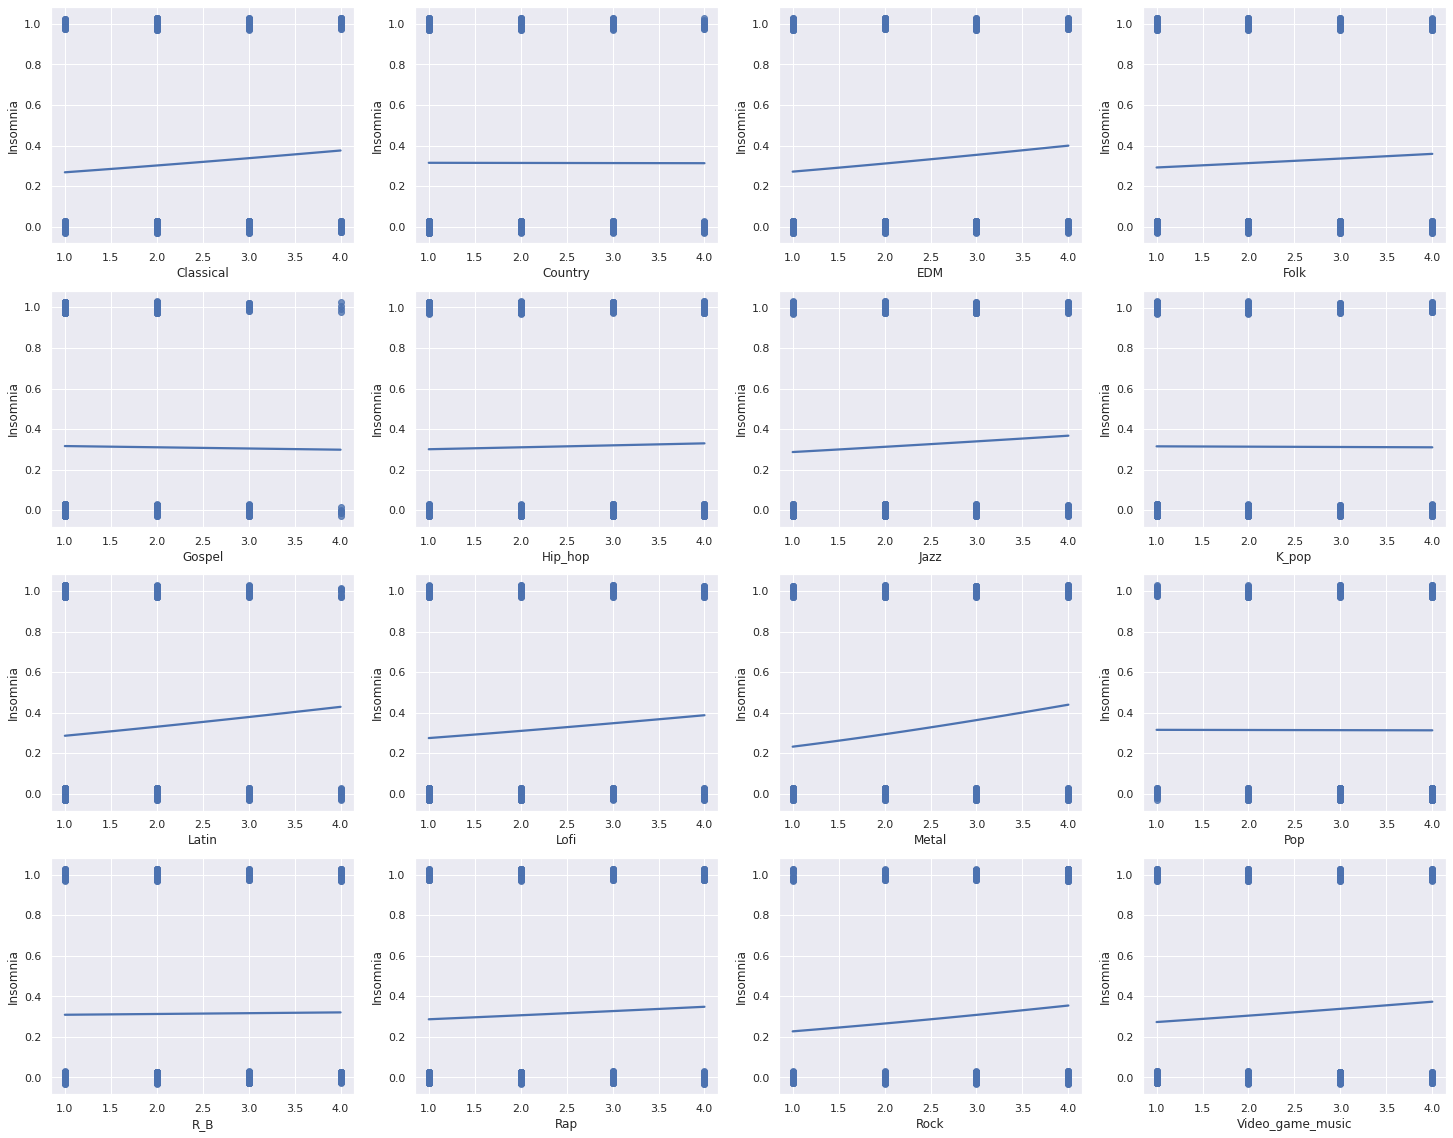

In [26]:
sns.set()

fig, axes = plt.subplots(4, 4, figsize=(25,20))

sns.regplot(x = "Classical", y = "Insomnia", y_jitter = 0.03, data = dat_taste, logistic = True, ci = None, ax=axes[0,0])
sns.regplot(x = "Country", y = "Insomnia", y_jitter = 0.03, data = dat_taste, logistic = True, ci = None, ax=axes[0,1])
sns.regplot(x = "EDM", y = "Insomnia", y_jitter = 0.03, data = dat_taste, logistic = True, ci = None, ax=axes[0,2])
sns.regplot(x = "Folk", y = "Insomnia", y_jitter = 0.03, data = dat_taste, logistic = True, ci = None, ax=axes[0,3])
sns.regplot(x = "Gospel", y = "Insomnia", y_jitter = 0.03, data = dat_taste, logistic = True, ci = None, ax=axes[1,0])
sns.regplot(x = "Hip_hop", y = "Insomnia", y_jitter = 0.03, data = dat_taste, logistic = True, ci = None, ax=axes[1,1])
sns.regplot(x = "Jazz", y = "Insomnia", y_jitter = 0.03, data = dat_taste, logistic = True, ci = None, ax=axes[1,2])
sns.regplot(x = "K_pop", y = "Insomnia", y_jitter = 0.03, data = dat_taste, logistic = True, ci = None, ax=axes[1,3])
sns.regplot(x = "Latin", y = "Insomnia", y_jitter = 0.03, data = dat_taste, logistic = True, ci = None, ax=axes[2,0])
sns.regplot(x = "Lofi", y = "Insomnia", y_jitter = 0.03, data = dat_taste, logistic = True, ci = None, ax=axes[2,1])
sns.regplot(x = "Metal", y = "Insomnia", y_jitter = 0.03, data = dat_taste, logistic = True, ci = None, ax=axes[2,2])
sns.regplot(x = "Pop", y = "Insomnia", y_jitter = 0.03, data = dat_taste, logistic = True, ci = None, ax=axes[2,3])
sns.regplot(x = "R_B", y = "Insomnia", y_jitter = 0.03, data = dat_taste, logistic = True, ci = None, ax=axes[3,0])
sns.regplot(x = "Rap", y = "Insomnia", y_jitter = 0.03, data = dat_taste, logistic = True, ci = None, ax=axes[3,1])
sns.regplot(x = "Rock", y = "Insomnia", y_jitter = 0.03, data = dat_taste, logistic = True, ci = None, ax=axes[3,2])
sns.regplot(x = "Video_game_music", y = "Insomnia", y_jitter = 0.03, data = dat_taste, logistic = True, ci = None, ax=axes[3,3])

I built the logistic regression model using all sixteen predictors against the response variable. Using an α = 0.1, three of the model coefficients are statistically significant, holding all other factors constant: the Intercept, Latin, and Metal.

The model overall seems to be a good fit for the data, given the LLR p-value 0.0039 < 0.1.

In examining the confusion matrix, the accuracy of the model in predicting whether or not someone would identify as having anxiety is approximately 38%, which does not meet my set minimum threshold of 70%.

In [27]:
formula_insomnia_ta = ("Insomnia ~ Classical + Country + EDM + Folk + Gospel + Hip_hop + Jazz + K_pop + Latin + Lofi + Metal + Pop + R_B + Rap + Rock + Video_game_music")
model_insomnia_ta = logit(formula = formula_insomnia_ta, data = dat_taste_train).fit()
print(model_insomnia_ta.summary())

pred_a = model_insomnia_ta.predict(exog = dat_taste_test)
cutoff = 0.5
y_pred = np.where(pred_a > cutoff, 1, 0)
y_actual = dat_taste_test["Anxiety"]
conf_matrix = pd.crosstab(y_actual, y_pred,
                          rownames = ["Actual"],
                          colnames = ["Predicted"],
                          margins = True)
print(conf_matrix)
acc_ta_insomnia = accuracy_score(y_actual, y_pred)
print(acc_ta_insomnia)

Optimization terminated successfully.
         Current function value: 0.605229
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:               Insomnia   No. Observations:                  575
Model:                          Logit   Df Residuals:                      558
Method:                           MLE   Df Model:                           16
Date:                Thu, 20 Apr 2023   Pseudo R-squ.:                 0.04794
Time:                        11:10:40   Log-Likelihood:                -348.01
converged:                       True   LL-Null:                       -365.53
Covariance Type:            nonrobust   LLR p-value:                  0.003912
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -2.7922      0.586     -4.768      0.000      -3.940      -1.644
Classical  

### Taste - OCD

The regression plots are similar to those for the previous response variables, though almost none of the variables seem to have a discernible relationship with OCD except for EDM, Jazz, and Metal. However, the linear relationships may not be meaningful given the categorical nature of the variables.

<AxesSubplot:xlabel='Video_game_music', ylabel='OCD'>

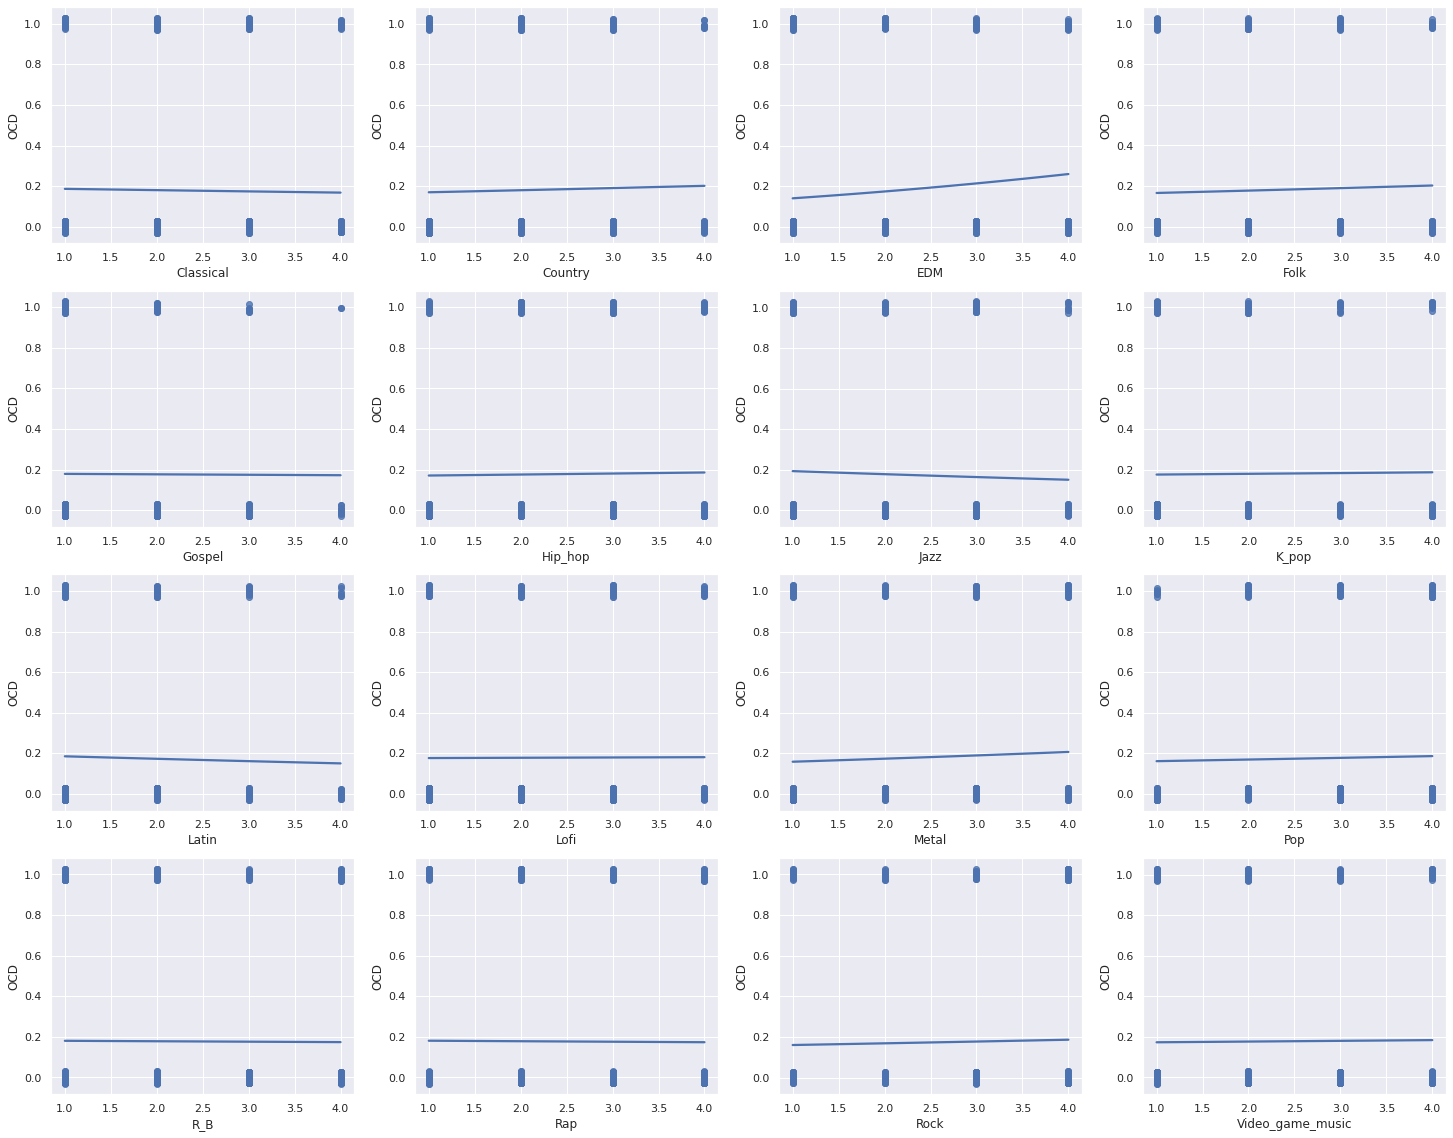

In [28]:
sns.set()

fig, axes = plt.subplots(4, 4, figsize=(25,20))

sns.regplot(x = "Classical", y = "OCD", y_jitter = 0.03, data = dat_taste, logistic = True, ci = None, ax=axes[0,0])
sns.regplot(x = "Country", y = "OCD", y_jitter = 0.03, data = dat_taste, logistic = True, ci = None, ax=axes[0,1])
sns.regplot(x = "EDM", y = "OCD", y_jitter = 0.03, data = dat_taste, logistic = True, ci = None, ax=axes[0,2])
sns.regplot(x = "Folk", y = "OCD", y_jitter = 0.03, data = dat_taste, logistic = True, ci = None, ax=axes[0,3])
sns.regplot(x = "Gospel", y = "OCD", y_jitter = 0.03, data = dat_taste, logistic = True, ci = None, ax=axes[1,0])
sns.regplot(x = "Hip_hop", y = "OCD", y_jitter = 0.03, data = dat_taste, logistic = True, ci = None, ax=axes[1,1])
sns.regplot(x = "Jazz", y = "OCD", y_jitter = 0.03, data = dat_taste, logistic = True, ci = None, ax=axes[1,2])
sns.regplot(x = "K_pop", y = "OCD", y_jitter = 0.03, data = dat_taste, logistic = True, ci = None, ax=axes[1,3])
sns.regplot(x = "Latin", y = "OCD", y_jitter = 0.03, data = dat_taste, logistic = True, ci = None, ax=axes[2,0])
sns.regplot(x = "Lofi", y = "OCD", y_jitter = 0.03, data = dat_taste, logistic = True, ci = None, ax=axes[2,1])
sns.regplot(x = "Metal", y = "OCD", y_jitter = 0.03, data = dat_taste, logistic = True, ci = None, ax=axes[2,2])
sns.regplot(x = "Pop", y = "OCD", y_jitter = 0.03, data = dat_taste, logistic = True, ci = None, ax=axes[2,3])
sns.regplot(x = "R_B", y = "OCD", y_jitter = 0.03, data = dat_taste, logistic = True, ci = None, ax=axes[3,0])
sns.regplot(x = "Rap", y = "OCD", y_jitter = 0.03, data = dat_taste, logistic = True, ci = None, ax=axes[3,1])
sns.regplot(x = "Rock", y = "OCD", y_jitter = 0.03, data = dat_taste, logistic = True, ci = None, ax=axes[3,2])
sns.regplot(x = "Video_game_music", y = "OCD", y_jitter = 0.03, data = dat_taste, logistic = True, ci = None, ax=axes[3,3])

I built the logistic regression model using all sixteen predictors against the response variable. Using an α = 0.1, three of the model coefficients are statistically significant, holding all other factors constant: the Intercept and EDM.

The model overall seems not to be a good fit for the data, given the LLR p-value 0.7292 > 0.1.

In examining the confusion matrix, the accuracy of the model in predicting whether or not someone would identify as having anxiety is approximately 37%, which does not meet my set minimum threshold of 70%.

In [29]:
formula_ocd_ta = ("OCD ~ Classical + Country + EDM + Folk + Gospel + Hip_hop + Jazz + K_pop + Latin + Lofi + Metal + Pop + R_B + Rap + Rock + Video_game_music")
model_ocd_ta = logit(formula = formula_ocd_ta, data = dat_taste_train).fit()
print(model_ocd_ta.summary())

pred_a = model_ocd_ta.predict(exog = dat_taste_test)
cutoff = 0.5
y_pred = np.where(pred_a > cutoff, 1, 0)
y_actual = dat_taste_test["Anxiety"]
conf_matrix = pd.crosstab(y_actual, y_pred,
                          rownames = ["Actual"],
                          colnames = ["Predicted"],
                          margins = True)
print(conf_matrix)
acc_ta_ocd = accuracy_score(y_actual, y_pred)
print(acc_ta_ocd)

Optimization terminated successfully.
         Current function value: 0.454117
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                    OCD   No. Observations:                  575
Model:                          Logit   Df Residuals:                      558
Method:                           MLE   Df Model:                           16
Date:                Thu, 20 Apr 2023   Pseudo R-squ.:                 0.02285
Time:                        11:10:43   Log-Likelihood:                -261.12
converged:                       True   LL-Null:                       -267.22
Covariance Type:            nonrobust   LLR p-value:                    0.7292
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -2.2441      0.689     -3.256      0.001      -3.595      -0.893
Classical  

## Comparison

After building all eight models, I isolated some statistics from the model summary outputs.

First, I compared the pseudo R^2 values for each model across each mental illness. This R^2 can be used to compare models built from the same data and to predict the same response variable and functions similarly to traditional R^2 values but for nonlinear models (Cameron & Windmeijer, 1997). 

In looking at the pseudo R^2 values, all models have very low values, suggesting that none of the models are very good at predicting the response variable. When looking at each mental illness, identity had higher pseudo R^2 values for Anxiety and OCD, and taste had higher pseudo R^2 values for Depression and Insomnia, suggesting that identity is slightly better at predicting anxiety and OCD, with taste being slightly better at predicting depression and insomnia. 

However, it's important to note that all R^2 values were < 0.1, with the difference between each value ranging from -0.024505 to 0.010150, suggesting that all models were very similar with marginal prediction power and differences.

In [30]:
#pseudo r^2 values
prsq = {'Anxiety': [model_anxiety_id.prsquared, model_anxiety_ta.prsquared, model_anxiety_id.prsquared - model_anxiety_ta.prsquared],
        'Depression': [model_depression_id.prsquared, model_depression_ta.prsquared, model_depression_id.prsquared - model_depression_ta.prsquared],
        'Insomnia': [model_insomnia_id.prsquared, model_insomnia_ta.prsquared, model_insomnia_id.prsquared - model_insomnia_ta.prsquared],
        'OCD': [model_ocd_id.prsquared, model_ocd_ta.prsquared, model_ocd_id.prsquared - model_ocd_ta.prsquared]}
  
# Creates pandas DataFrame.
prsq_df = pd.DataFrame(prsq, index=['Identity','Taste', 'Difference'])
  
# print the data
prsq_df

,Anxiety,Depression,Insomnia,OCD
Identity,0.031079,0.029496,0.023438,0.033001
Taste,0.029937,0.052997,0.047944,0.022851
Difference,0.001142,-0.023500,-0.024505,0.010150


Then, I compared the LLR p-values for each model. Using a 90% confidence interval, all models except Taste-OCD were statistically significant, which suggests that, for all models except for Taste-OCD, the null hypothesis can be rejected, suggesting that the estimated regression coefficients for the predictors do have a relationship with the response variables. 

In [31]:
#lrr r^2 values
lrr_r2 = {'Anxiety': [model_anxiety_id.llr_pvalue , model_anxiety_ta.llr_pvalue],
        'Depression': [model_depression_id.llr_pvalue, model_depression_ta.llr_pvalue],
        'Insomnia': [model_insomnia_id.llr_pvalue, model_insomnia_ta.llr_pvalue],
        'OCD': [model_ocd_id.llr_pvalue, model_ocd_ta.llr_pvalue]}
  
# Creates pandas DataFrame.
lrr_r2_df = pd.DataFrame(lrr_r2, index=['Identity','Taste'])
  
# print the data
lrr_r2_df

,Anxiety,Depression,Insomnia,OCD
Identity,0.002223,0.002790,0.028735,0.024119
Taste,0.108650,0.000368,0.003912,0.729225


Lastly, I extracted the accuracies from each and built a dataframe comparing the accuracies for each mental illness for both identity and taste.

Looking at raw numbers, Identity had higher accuracy across each mental illness than Taste. However, only Identity-Insomnia and Identity-OCD met or exceeded my set accuracy threshold of 70%. Also interesting to note is that OCD had the largest difference in model accuracies, while both models for Anxiety had the exact same accuracies.

I performed statistical testing to compare the given accuracies. I performed a t-test, as t-tests are better for smaller n, and the calculated p-value 0.0466 < α 0.1, suggesting that the Identity accuracies are statistically significantly higher than the Taste accuracies. However, due to the small sample size, this may not be super meaningful. 

I also performed a Wilcoxon Matched Signed Rank Test and calculated a p-value 0.1088 > α 0.1, which suggests that the accuracies may be similar or the same across each model. 

With these comparisons, while my hypothesis of Identity having higher accuracy rates than Taste is true in looking at the raw numbers, statistically, this can not be proven true without further testing and modeling. 

In [32]:
#model accuracies
comp = {'Anxiety': [acc_id_anxiety, acc_ta_anxiety],
        'Depression': [acc_id_depression, acc_ta_depression],
        'Insomnia': [acc_id_insomnia, acc_ta_insomnia],
        'OCD': [acc_id_ocd, acc_ta_ocd]}
  
# Creates pandas DataFrame.
comp_df = pd.DataFrame(comp, index=['Identity','Taste'])
  
# print the data
comp_df

,Anxiety,Depression,Insomnia,OCD
Identity,0.659722,0.569444,0.736111,0.812500
Taste,0.659722,0.500000,0.375000,0.368056


In [33]:
#create identity dataframe and calculate variance
identity = pd.DataFrame([acc_id_anxiety, acc_id_depression, acc_id_insomnia, acc_id_ocd])
print(np.var(identity))

#create taste dataframe and calculate variance
taste = pd.DataFrame([acc_ta_anxiety, acc_ta_depression, acc_ta_insomnia, acc_ta_ocd])
print(np.var(taste))

0    0.008126
dtype: float64
0    0.014046
dtype: float64


In [34]:
#ttest
stats.ttest_ind(identity, taste, equal_var=False)


Ttest_indResult(statistic=array([2.54454603]), pvalue=array([0.04656224]))

In [35]:
#flattening dataframes to be 1-dimensional arrays
i = identity.values.flatten()
t = taste.values.flatten()

#wilcoxon signed rank test
stats.wilcoxon(i, t, alternative = "two-sided")

/usr/lib/python3.7/site-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


WilcoxonResult(statistic=0.0, pvalue=0.10880943004054568)

## Limitations

Throughout this analysis, there were also some significant limitations. 

One limitation was the survey itself. The form creator developed the survey using a Google form and distributed it online through social media platforms (i.e. Reddit, Discord, etc.), as well as in person through business-card-esque ads to post around local areas (i.e. libraries, parks, etc.) (Rasgaitis, 2022). While users were not restricted by location or age, the form being distributed locally limits the locations and adds bias that skews the data in favor of those in that area, even with the form also being distributed anonymously online, as this may also add some bias given that certain demographics are more inclined towards social media platforms, especially those like Reddit and Discord that are more niche and reach younger audiences. While no questions collected location information and Google forms do not collect that meta data, the distribution of self-reported ages on the form definitely is skewed to the right, as a majority of respondents fell under the age of 40, with the largest group being between 20 and 30 years of age. 

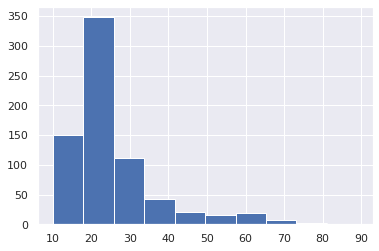

In [36]:
#plotting histogram of Age variable
plt.hist(dat["Age"])
plt.show() 

Something else to note in regards to the form is the questions asked. Generating effective forms for data collection can be challenging, as one does not want to create a long and exhausting form that could fatigue users and lead to lower completion rates and a lot of partial data entries but also wants the data collection to be as comprehensive as possible. 

Respecting these limitations in terms of the number of questions and nature of the questions asked, I believe that some questions, especially those in regards to the frequency respondents listen to each genre, could be changed or even removed. There are many different genres in the world, and while this form made great strides in being as all-encompassing as possible in terms of included genres, many of the genres could be considered overlapping or even subgrenres of others, and without distinct definitions for each genre or explicit examples within the genres, these questions could be considered unclear. One example could be how Metal could be considered a subgenre of Rock or how Folk music could fall within many different genres such as Country, Gosepl, or Rock. Because of this, while I did not perform any multicollinearity tests for this specific analysis, multicollinearity could definitely be a problem, especially within the Music Taste models, as many genres could very well have multicollinearity and detract from the effectiveness and accuracy of the models. 

Similar to the genres, the mental illnesses selected for analysis could have been narrowed or changed. While these four (anxiety, depression, insomnia, and OCD) are commonly-known and familiar to the mass majority, these too could have some problems with overlap or confusion. One prominent example is that OCD is considered an anxiety disorder, which could lead to those two having a lot of overlap in terms of correlations and model variables. 

Something else to note with the mental illness rankings is that the values are self-reported and on a scale of 0 to 10. Self-reporting is expected with this type of anonymous survey; however, especially since many people still commonly refer to everyday feelings of nervousness, sadness, tiredness, or nitpickiness as experiencing anxiety, depression, insomnia, and OCD, respectively. Which, while these feelings are also valid, they do not necessarily mean respondents truly experience those mental health struggles, which can cause some issues within itself. 

Alongside that, the scale being 0-10 leaves a lot of movement room for respondents, which decreases the reliability of the ratings. Even recoding the response values to be binary left limitations and detracted from model reliability, as 0-5 was recoded to 0 and 6-10 was recoded to 1, which is grouping people who could have vastly different experiences into two categories, as well as grouping them unevenly since six categories could fall under 0 and five under 1. 

Another limitation was simply the sample size for the models. While I could have built numerous models, it would have been too time-consuming and lengthy for this analysis, so the sample of accuracies was very small, which led to potentially inaccurate Wilcoxon signed rank test and ttest values. This is something that could be explored in further research.

## Future Analysis

If I were to pursue this research further in the future, I would probably limit the data some and focus in on one or two of the mental illnesses. From there, I could do more in-depth regressional analyses and begin working on variables selection and model selection to better-model the mental illnesses with the given data. 

Building more models would also allow for more accurate ttests and Wilcoxon signed rank tests, as there would be more data to do comparisons and to work towards statistical significance. 

I could also build entirely different models with different distribution families after more-deeply exploring the data and relationships and residuals alongside the response variables. Maybe this could require the response variables be un-coded so that they're what the originally-reported values were instead of the binary ones I coded, which could be very interesting to explore and compare these with the logistic ones I built for this analysis.

I would also enjoy exploring the survey instrument itself and could look into performing validity and reliability studies to improve upon or shrink the survey. From there, I could reach out to the original creator about another round of data collection, or I could do more research into music and mental health survey items that are from validated scales and do some analysis comparing scales and data collection effectiveness. 

## Term Index

**LLR p-value**: The Log-Likelihood Ratio p-value is used in place of the coefficient of determination (R^2) and provides a "p-value from a likelihood-ratio test of the model at hand versus the null model" (Adams, 2020).

**Music Identity**: Music Identity can be defined as "social and cultural roles within music" (Hargreaves et al., 2002).

**Music Taste**: Music Taste is defined as "individual patterns of preference within music" (Hargreaves et al., 2002).

**Pseudo R-Squared**: Pseudo R-squared "is defined as the proportionate reduction in uncertainty, measured by Kullback-Leibler divergence, due to the inclusion of regressors. Under further conditions concerning the conditional mean function it can also be interpreted as the fraction of uncertainty explained by the fitted model" (Cameron & Windmeijer, 1997).

**Wilcoxon Signed Rank Test**: This statistical test is an alternative to the t-test for comparing small samples and is "very appropriate for a repeated measure design where the same subjects are evaluated under two different conditions" (Scheff, 2016).

## Survey Content (Rasgaitis, 2022)
*   **Timestamp**: Date and time when form was submitted
*   **Age**: Respondent's age
*   **Primary streaming service**: Respondent's primary streaming service
 *  Apple Music
 *  Spotify
 *  Youtube Music
 *  Other streaming service
 *  I do not use a streaming service
*   **Hours per day**: Number of hours the respondent listens to music per day
*   **While working**: Does the respondent listen to music while studying/working?
 *  Yes
 *  No
*   **Instrumentalist**: Does the respondent play an instrument regularly?
 *  Yes
 *  No
*   **Composer**: Does the respondent compose music?
 *  Yes
 *  No
*   **Fav genre**: Respondents' favorite or top genre
 *  Classical
 *  Country
 *  EDM
 *  Folk
 *  Gosepl
 *  Hip hop
 *  Jazz
 *  K pop
 *  Latin
 *  Lofi
 *  Metal
 *  Pop
 *  R&B
 *  Rap
 *  Rock
 *  Video game music
*   **Exploratory**: Does the respondent actively explore new artists/genres?
 *  Yes
 *  No
*   **Foreign languages**: Does the respondent regularly listen to music with lyrics in a language they are not fluent in?
 *  Yes
 *  No
*   **BPM**: Beats per minute of favorite genre
*   **Frequency**: How frequently the respondent listen to ___ music (for each genre listed above)
 *  Never
 *  Rarely
 *  Sometimes
 *  Very frequently
*  **Anxiety/Depression/Insomnia/OCD**: Self-reported experience with each on a scale of 0-10
 *  0: I do not experience this
 *  10: I experience this regularly, constantly, and/or to an extreme
*   **Music effects**: Does music improve/worsen respondent's mental health conditions?
 *  Improve
 *  Worsen
 *  No effect
*   **Permissions**: Permissions to publicize data (consent)


## Citations
Adams, S. A. (2020, June 17). *An introduction to logistic regression in python with statsmodels and scikit-learn*. Medium. Retrieved April 18, 2023, from https://levelup.gitconnected.com/an-introduction-to-logistic-regression-in-python-with-statsmodels-and-scikit-learn-1a1fb5ce1c13 

Bedre, R. (2021, January 3). *Logistic Regression in Python (feature selection, model fitting, and prediction)*. Data science blog. Retrieved April 17, 2023, from https://www.reneshbedre.com/blog/logistic-regression.html 

Hargreaves, D. J., Miell, D., &amp; MacDonald, R. A. R. (2002, January). *What are musical identities, and why are they important?* ResearchGate. Retrieved April 17, 2023, from https://www.researchgate.net/publication/252461217_What_are_musical_identities_and_why_are_they_important

Cameron, A. C., Windmeijer, F. A. G., An R-squared measure of goodness of fit for some common nonlinear regression models, Journal of Econometrics, Volume 77, Issue 2, 1997, Pages 329–342, ISSN 0304–4076,
https://doi.org/10.1016/S0304-4076(96)01818-0. 

Rasgaitis, C. (2022, November 21). *Music &amp; Mental Health Survey Results*. Kaggle. Retrieved April 11, 2023, from https://www.kaggle.com/datasets/catherinerasgaitis/mxmh-survey-results?resource=download 

Scheff, S. W. (2016). Nonparametric statistics. Fundamental Statistical Principles for the Neurobiologist, 157–182. https://doi.org/10.1016/b978-0-12-804753-8.00008-7 

The SciPy Community. (n.d.). *Scipy.stats.ttest_ind*. scipy.stats.ttest_ind - SciPy v1.10.1 Manual. Retrieved April 17, 2023, from https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html 